In [12]:
import pymysql

try:
    connection = pymysql.connect(
        host='localhost',         # or use '127.0.0.1'
        user='root',
        password='Arashev3211!',
        database='nashville_housing',
        port=3306                 # Ensure this matches your MySQL configuration
    )
    print("Connection successful!")

    # Create a cursor to interact with the database
    with connection.cursor() as cursor:
        # Example query
        cursor.execute("SHOW TABLES;")
        tables = cursor.fetchall()
        print("Tables in the database:", tables)

    # Commit changes if any (optional, for transactions)
    connection.commit()

except pymysql.MySQLError as e:
    print("Error connecting to MySQL:", e)
finally:
    # Ensure the connection is closed
    if connection:
        connection.close()
        print("Connection closed!")


Connection successful!
Tables in the database: (('acreage_ranges',), ('cities',), ('features',), ('highvaluesalesbypropertytypeandcity',), ('land_use_mapping',), ('owners',), ('ownerships',), ('predictions',), ('properties',), ('property_analysis',), ('recenthighvaluesales',), ('recentsales',), ('sales',), ('salestrends',), ('undervaluedpropertiesview',), ('valuation',), ('xgpredictions',), ('yearlypropertyappreciation',))
Connection closed!


In [6]:
!pip install xgboost


   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
    --------------------------------------- 1.6/124.9 MB 10.5 MB/s eta 0:00:12
   - -------------------------------------- 4.2/124.9 MB 11.4 MB/s eta 0:00:11
   -- ------------------------------------- 6.8/124.9 MB 11.6 MB/s eta 0:00:11
   --- ------------------------------------ 10.2/124.9 MB 13.0 MB/s eta 0:00:09
   ---- ----------------------------------- 13.9/124.9 MB 13.8 MB/s eta 0:00:09
   ----- ---------------------------------- 17.6/124.9 MB 14.6 MB/s eta 0:00:08
   ------ --------------------------------- 20.7/124.9 MB 14.9 MB/s eta 0:00:08
   ------- -------------------------------- 24.4/124.9 MB 15.0 MB/s eta 0:00:07
   -------- ------------------------------- 27.8/124.9 MB 15.2 MB/s eta 0:00:07
   --------- ------------------------------ 30.7/124.9 MB 15.0 MB/s eta 0:00:07
   ---------- ----------------------------- 34.1/124.9 MB 15.1 MB/s eta 0:00:07
   ----------- ---------------------------- 37.0/124

In [16]:
import pymysql
import pandas as pd
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# MySQL connection configuration
db_config = {
    'host': 'localhost',
    'user': 'root',
    'password': 'Arashev3211!',
    'database': 'nashville_housing',
    'port': 3306
}

def fetch_data(query):
    """Fetch data from MySQL based on the query."""
    try:
        connection = pymysql.connect(**db_config)
        print("Connected to MySQL successfully!")
        data = pd.read_sql(query, connection)
        print(f"Data fetched successfully! {len(data)} records retrieved.")
        return data
    except pymysql.MySQLError as e:
        print("Error fetching data from MySQL:", e)
        exit()
    finally:
        if connection:
            connection.close()
            print("Connection closed!")

def preprocess_data(data, selected_features):
    """Preprocess data for the model."""
    X = data[selected_features].values
    y_actual = data['sale_price'].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print("Data preprocessing completed!")
    return X_scaled, y_actual

def train_xgboost_model(X_scaled, y_actual):
    """Train the XGBoost regression model."""
    print("Training the XGBoost model...")
    model = XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        objective='reg:squarederror',
        random_state=42
    )
    model.fit(X_scaled, y_actual)
    print("Model training completed!")
    return model

def insert_predictions_xgboost(data, predicted_prices, y_actual):
    """Insert or update predictions in the MySQL database."""
    try:
        connection = pymysql.connect(**db_config)
        print("Reconnected to MySQL!")

        # Prepare data for batch insertion
        predictions_data = [
            (int(row['property_id']), float(predicted_prices[i]), float(y_actual[i]))
            for i, row in data.iterrows()
        ]

        # Insert data into XGpredictions table
        with connection.cursor() as cursor:
            cursor.executemany("""
                INSERT INTO XGpredictions (property_id, predicted_sale_price, actual_sale_price)
                VALUES (%s, %s, %s)
                ON DUPLICATE KEY UPDATE 
                    predicted_sale_price = VALUES(predicted_sale_price),
                    actual_sale_price = VALUES(actual_sale_price)
            """, predictions_data)

            # Commit the transaction
            connection.commit()
            print(f"{cursor.rowcount} predictions inserted/updated successfully!")
    except pymysql.MySQLError as e:
        print("Error inserting predictions into MySQL:", e)
    finally:
        if connection:
            connection.close()
            print("Connection closed!")

# Main Workflow
if __name__ == "__main__":
    # SQL query to fetch data
    query = """
        SELECT 
            p.property_id,
            v.total_value, 
            v.building_value, 
            v.land_value, 
            f.bedrooms, 
            f.full_bath, 
            f.half_bath, 
            f.age,
            v.valuation_to_sale_price_ratio,
            s.price_per_sqft,
            s.sale_price
        FROM properties p
        JOIN valuation v ON p.property_id = v.property_id
        JOIN features f ON p.property_id = f.property_id
        JOIN sales s ON p.property_id = s.property_id;
    """

    # Step 1: Fetch data
    data = fetch_data(query)

    # Step 2: Preprocess data
    selected_features = [
        'total_value', 'building_value', 'land_value', 
        'bedrooms', 'full_bath', 'half_bath', 
        'age', 'valuation_to_sale_price_ratio', 'price_per_sqft'
    ]
    X_scaled, y_actual = preprocess_data(data, selected_features)

    # Step 3: Train the XGBoost model
    xgboost_model = train_xgboost_model(X_scaled, y_actual)

    # Step 4: Generate predictions
    predicted_prices = xgboost_model.predict(X_scaled)
    print(f"Predictions generated for {len(predicted_prices)} records.")

    # Step 5: Calculate evaluation metrics
    mae = mean_absolute_error(y_actual, predicted_prices)
    mse = mean_squared_error(y_actual, predicted_prices)
    rmse = np.sqrt(mse)
    print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")

    # Step 6: Insert predictions into MySQL
    insert_predictions_xgboost(data, predicted_prices, y_actual)


Connected to MySQL successfully!


C:\Users\Jepbar\AppData\Local\Temp\ipykernel_2400\1108567538.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query, connection)


Data fetched successfully! 51076 records retrieved.
Connection closed!
Data preprocessing completed!
Training the XGBoost model...
Model training completed!
Predictions generated for 51076 records.
MAE: 17257.64, MSE: 790196914.43, RMSE: 28110.44
Reconnected to MySQL!
63616 predictions inserted/updated successfully!
Connection closed!


In [24]:
pip install shap

Generating SHAP summary plot for XGBoost model...


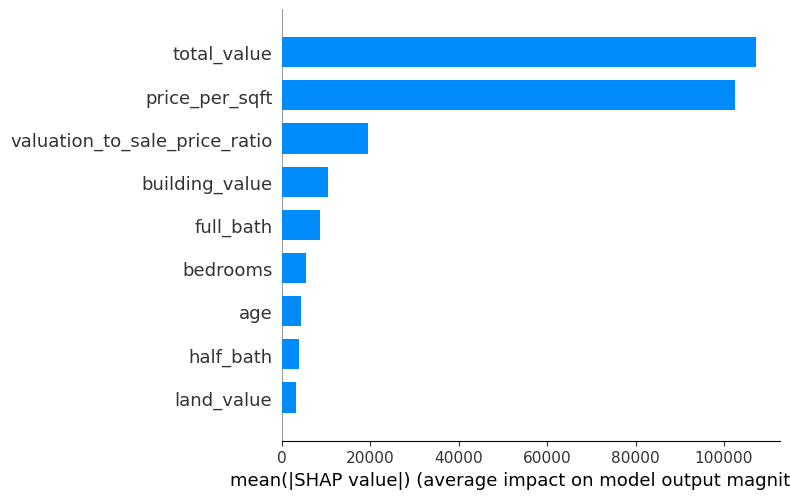

Generating SHAP detailed summary plot...


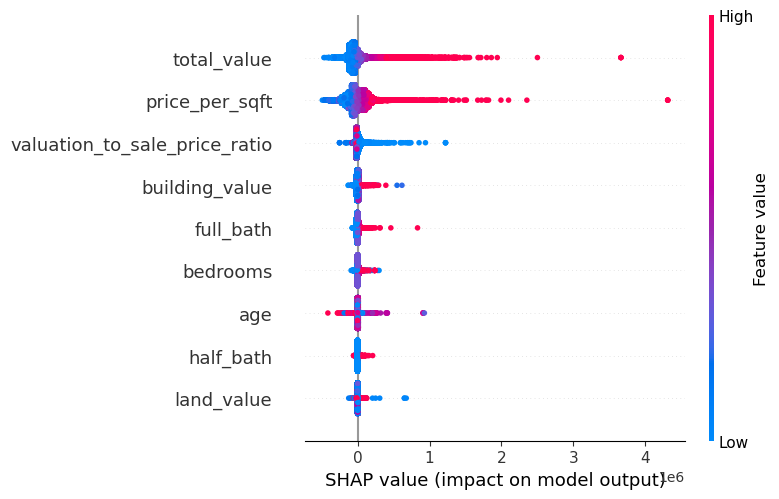

In [25]:
import shap
import matplotlib.pyplot as plt

def explain_xgboost_model(model, X_scaled, selected_features):
    # Initialize the SHAP explainer
    explainer = shap.Explainer(model)
    
    # Generate SHAP values
    shap_values = explainer(X_scaled)
    
    # Summary plot of feature importance
    print("Generating SHAP summary plot for XGBoost model...")
    shap.summary_plot(shap_values, feature_names=selected_features, plot_type="bar")
    plt.show()

    # Detailed feature contributions
    print("Generating SHAP detailed summary plot...")
    shap.summary_plot(shap_values, feature_names=selected_features)
    plt.show()

# Call the function for XGBoost
explain_xgboost_model(xgboost_model, X_scaled, selected_features)
